In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [3]:
df = pd.read_excel('Sample_GaugeData.xlsx', sheet_name='RN',
     engine='openpyxl').iloc[4:-1,0:20].melt(id_vars=["GMT"])


## Removing all Na values ##
df = df[df['value'].notna()]

## Converting values to float ##
df.value = df.value.astype(float)


## Processing data - Might be some small errors in the calculations ##
df['DayMax'] = df.groupby(df['GMT'].dt.date)['value'].transform('max')
df['DayAvg'] = df.groupby(df['GMT'].dt.date)['value'].transform(np.mean)*288
df['DayMin'] = df.groupby(df['GMT'].dt.date)['value'].transform('min')
df['weekMax'] = df.groupby(df['GMT'].dt.isocalendar().week)['value'].transform('max')
df['weektotal'] = df.groupby(df['GMT'].dt.isocalendar().week)['value'].transform(np.mean)*2016


## Creating function for encoding data ##
def encode_data(feature_name):
    dicts = {}
    unique_values = list(df[feature_name].unique())
    for i in range(len(unique_values)):
        dicts[unique_values[i]] = i
    return dicts

## Encoding data ##
df['GMT'].replace(encode_data('GMT'),inplace = True)
df["variable"].replace(encode_data("variable"),inplace = True)

In [17]:
df.head()

,GMT,variable,value,DayMax,DayAvg,DayMin,weekMax,weektotal
0,0,0,0.0,1.33,0.85471,0.0,7.83,11.122688
1,1,0,0.0,1.33,0.85471,0.0,7.83,11.122688
2,2,0,0.0,1.33,0.85471,0.0,7.83,11.122688
3,3,0,0.0,1.33,0.85471,0.0,7.83,11.122688
4,4,0,0.0,1.33,0.85471,0.0,7.83,11.122688


In [5]:
def show_corr_heatmap(df):
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

    plt.figure(figsize=(20, 10))

    corr_matrix = df.corr()

    # mask to hide the upper triangle of the symmetric corr-matrix
    # mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    heatmap = sns.heatmap(

        # correlation matrix
        corr_matrix,

        # mask the top triangle of the matrix
        # mask=mask,

        # two-contrast color, different color for + -
        cmap="PiYG",

        # color map range
        vmin=-1, vmax=1,

        # show corr values in the cells
        annot=True
    )

    # set a title
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

    plt.show()

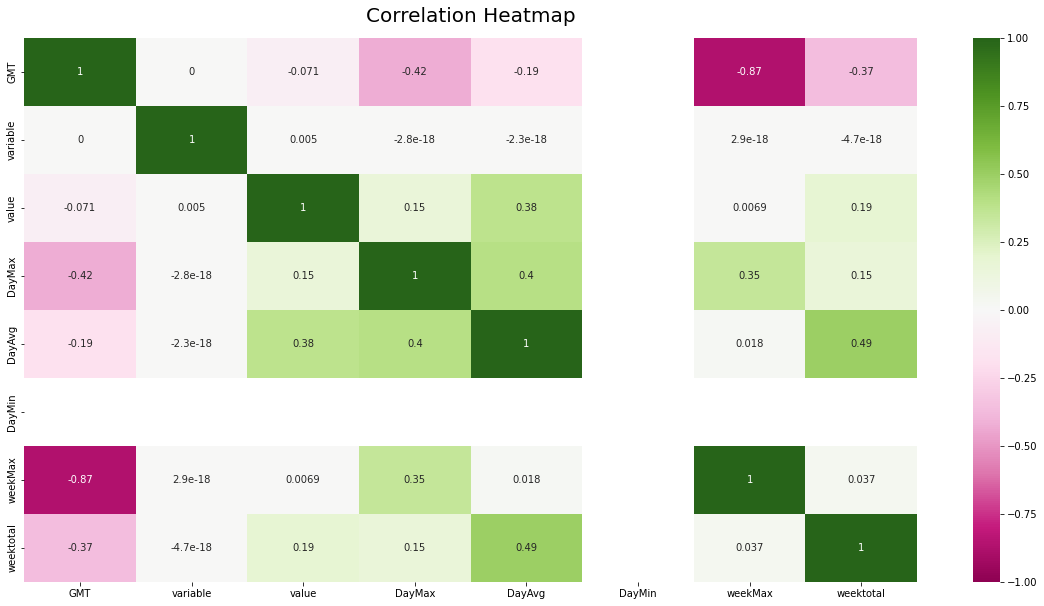

In [6]:
show_corr_heatmap(df)

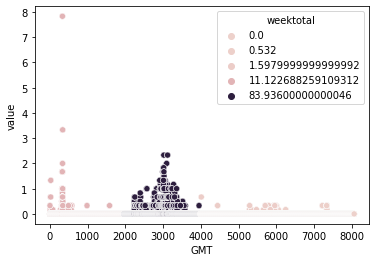

In [15]:
_=sns.scatterplot(data=df, x='GMT', y='value', hue='weektotal')

<AxesSubplot:>

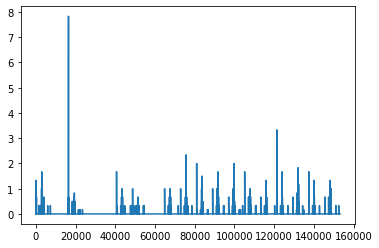

In [31]:
df['value'].plot()

In [113]:
X = df.drop(['DayAvg', 'GMT','variable'], axis=1) #all columns except PRCP and RAIN, as both give the answer away.
y = df["DayAvg"]

In [108]:
random_state = 44
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

Epoch 1/10
3024/3024 [==============================] - 11s 2ms/step - loss: 120.2429 - val_loss: 62.9236
Epoch 2/10
3024/3024 [==============================] - 6s 2ms/step - loss: 62.0251 - val_loss: 61.5911
Epoch 3/10
3024/3024 [==============================] - 4s 1ms/step - loss: 60.9592 - val_loss: 61.0791
Epoch 4/10
3024/3024 [==============================] - 4s 1ms/step - loss: 60.1282 - val_loss: 59.9073
Epoch 5/10
3024/3024 [==============================] - 4s 1ms/step - loss: 59.2659 - val_loss: 59.3158
Epoch 6/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.7846 - val_loss: 59.6975
Epoch 7/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.4143 - val_loss: 59.5047
Epoch 8/10
3024/3024 [==============================] - 4s 1ms/step - loss: 58.1162 - val_loss: 58.6342
Epoch 9/10
3024/3024 [==============================] - 4s 1ms/step - loss: 57.8816 - val_loss: 58.5334
Epoch 10/10
3024/3024 [==============================] - 4s 1m

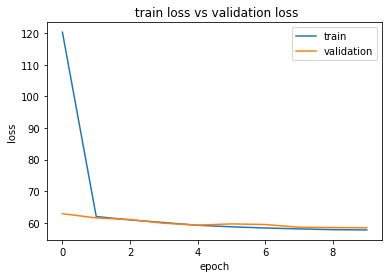

In [109]:
model = keras.Sequential()
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1))
model.compile(optimizer='Adam', loss='mse')

# This builds the model for the first time:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [115]:
X.shape

(120945, 6)

In [112]:
model = keras.Sequential()
model.add(keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1])))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1))
model.compile(optimizer='Adam', loss='mse')

# This builds the model for the first time:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

Epoch 1/50


ValueError: in user code:

    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\luke kelly\appdata\local\programs\python\python37\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_44" is incompatible with the layer: expected shape=(None, 96756, 5), found shape=(None, 5)
